# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [112]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [113]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [114]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [115]:
centroids = torch.rand(n_clusters, 2)*70-35

In [116]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

用来从一个多元正态分布中采样，均值为m，采样n_samples个

In [117]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [118]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [119]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

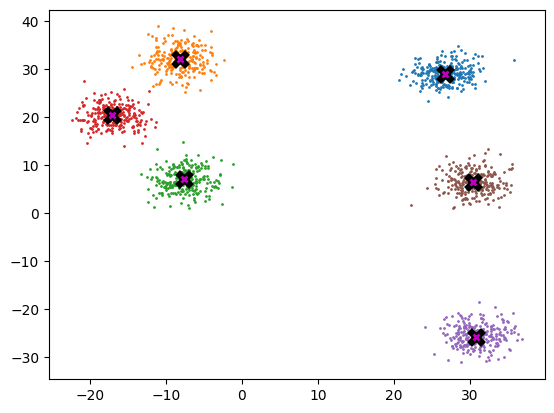

In [120]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [121]:
data[0]#the context in data is site

tensor([26.204, 26.349])

In [122]:
midp = data.mean(0)
midp#the center

tensor([ 9.222, 11.604])

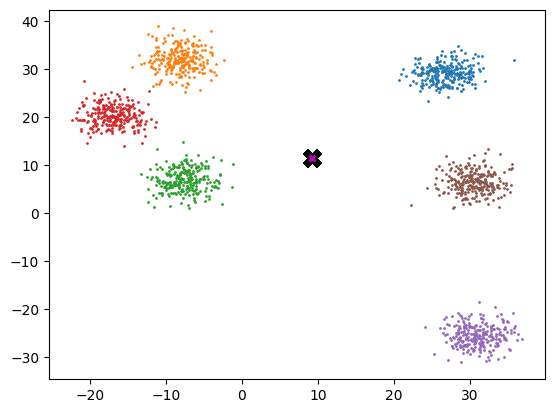

In [123]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [124]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [125]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

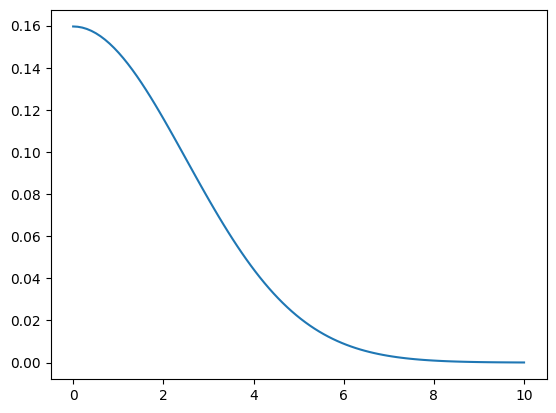

In [126]:
plot_func(partial(gaussian, bw=2.5))#partial用来指定原函数的一些参数值

In [127]:
partial

functools.partial

In our implementation, we choose the bandwidth to be 2.5.

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.找到一个能覆盖1/3数据的方差

In [128]:
def tri(d, i): return (-d+i).clamp_min(0)/i

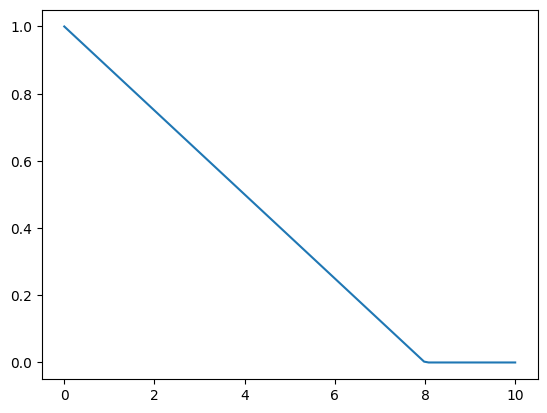

In [129]:
plot_func(partial(tri, i=8))

In [130]:
X = data.clone()
x = data[0]

In [43]:
x

tensor([-14.167, -17.772])

In [45]:
x.shape,X.shape,x[None].shape,data.shape

(torch.Size([2]),
 torch.Size([1500, 2]),
 torch.Size([1, 2]),
 torch.Size([1500, 2]))

In [46]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 5.465, -1.826],
        [ 5.980,  3.467],
        [ 3.635,  2.243],
        [ 2.633,  3.797],
        [ 3.951,  6.092],
        [ 8.437, -0.147],
        [ 2.900,  3.063]])

In [47]:
(x-X)[:8]#broadcast

tensor([[ 0.000,  0.000],
        [ 5.465, -1.826],
        [ 5.980,  3.467],
        [ 3.635,  2.243],
        [ 2.633,  3.797],
        [ 3.951,  6.092],
        [ 8.437, -0.147],
        [ 2.900,  3.063]])

In [56]:
dist = ((x-X)**2)
dist.shape,dist,dist.sum(1)#按第一维列相加就是把同一行中的数据相加

(torch.Size([1500, 2]),
 tensor([[   0.000,    0.000],
         [  29.866,    3.335],
         [  35.760,   12.018],
         ...,
         [ 503.225,  809.027],
         [ 386.805, 1048.054],
         [ 340.997,  982.254]]),
 tensor([   0.000,   33.201,   47.778,  ..., 1312.253, 1434.859, 1323.252]))

In [50]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt()
#dist.shape
dist[:8]

tensor([0.000, 5.762, 6.912, 4.271, 4.621, 7.261, 8.439, 4.218])

In [51]:
dist.shape

torch.Size([1500])

In [57]:
weight = gaussian(dist, 2.5)
weight#距离越大，使它获得的权重越小

tensor([[    0.160,     0.160],
        [    0.000,     0.066],
        [    0.000,     0.000],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [58]:
weight.shape,X.shape

(torch.Size([1500, 2]), torch.Size([1500, 2]))

In [60]:
weight[:,None].shape

torch.Size([1500, 1, 2])

In [61]:
weight[:,None]*X

tensor([[[    -2.261,     -2.836],
         [    -3.133,     -2.545],
         [    -3.215,     -3.389],
         ...,
         [     1.319,      1.703],
         [     0.878,      2.330],
         [     0.686,      2.165]],

        [[    -0.000,     -1.165],
         [    -0.000,     -1.045],
         [    -0.000,     -1.392],
         ...,
         [     0.000,      0.699],
         [     0.000,      0.957],
         [     0.000,      0.889]],

        [[    -0.000,     -0.000],
         [    -0.000,     -0.000],
         [    -0.000,     -0.000],
         ...,
         [     0.000,      0.000],
         [     0.000,      0.000],
         [     0.000,      0.000]],

        ...,

        [[    -0.000,     -0.000],
         [    -0.000,     -0.000],
         [    -0.000,     -0.000],
         ...,
         [     0.000,      0.000],
         [     0.000,      0.000],
         [     0.000,      0.000]],

        [[    -0.000,     -0.000],
         [    -0.000,     -0.000],
         [  

In [62]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))#计算下x与各个点之间的距离
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)#按照距离分配权重
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()#更新当前的点，换下一个点继续更新为基于权重的加权平均值

In [66]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [67]:
%time X=meanshift(data)

CPU times: user 771 ms, sys: 0 ns, total: 771 ms
Wall time: 771 ms


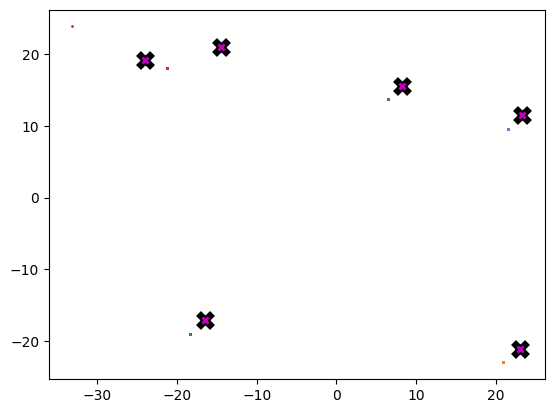

In [68]:
plot_data(centroids+2, X, n_samples)

## Animation

In [69]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [70]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [71]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [72]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [73]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()#第一个维度变为batchsize，所以相加的维度变为了2

In [74]:
dist_b(X, x)

tensor([[ 0.000,  5.762,  6.912,  ..., 36.225, 37.880, 36.377],
        [ 5.762,  0.000,  5.318,  ..., 38.558, 39.557, 37.997],
        [ 6.912,  5.318,  0.000,  ..., 42.726, 44.072, 42.534],
        [ 4.271,  4.462,  2.645,  ..., 40.264, 41.729, 40.204],
        [ 4.621,  6.297,  3.364,  ..., 40.838, 42.493, 40.986]])

In [75]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [76]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [77]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[0.199, 0.003, 0.001,  ..., 0.000, 0.000, 0.000],
        [0.003, 0.199, 0.006,  ..., 0.000, 0.000, 0.000],
        [0.001, 0.006, 0.199,  ..., 0.000, 0.000, 0.000],
        [0.020, 0.017, 0.083,  ..., 0.000, 0.000, 0.000],
        [0.014, 0.001, 0.048,  ..., 0.000, 0.000, 0.000]])

In [78]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [79]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [81]:
num = (weight[...,None]*X[None]).sum(1)
num.shape,num

(torch.Size([5, 2]),
 tensor([[-119.400, -137.155],
         [-226.752, -206.096],
         [-267.690, -282.296],
         [-363.511, -396.659],
         [-244.396, -289.064]]))

In [82]:
num

tensor([[-119.400, -137.155],
        [-226.752, -206.096],
        [-267.690, -282.296],
        [-363.511, -396.659],
        [-244.396, -289.064]])

In [83]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[-119.400, -137.155],
        [-226.752, -206.096],
        [-267.690, -282.296],
        [-363.511, -396.659],
        [-244.396, -289.064]])

In [84]:
weight@X

tensor([[-119.400, -137.155],
        [-226.752, -206.096],
        [-267.690, -282.296],
        [-363.511, -396.659],
        [-244.396, -289.064]])

In [85]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [86]:
num/div

tensor([[-16.012, -18.393],
        [-19.011, -17.279],
        [-19.307, -20.360],
        [-18.011, -19.653],
        [-17.397, -20.577]])

In [87]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [88]:
data = data.cuda()

In [89]:
X = meanshift(data).cpu()

In [90]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

6.32 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


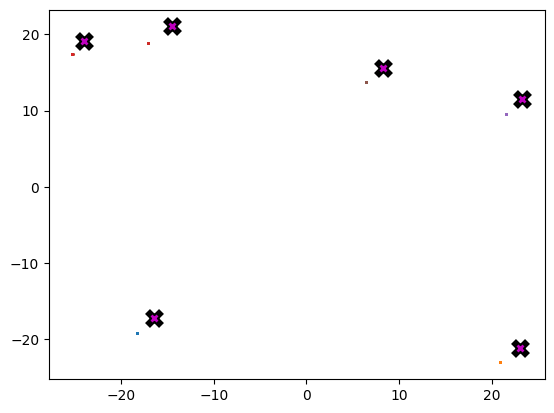

In [91]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D

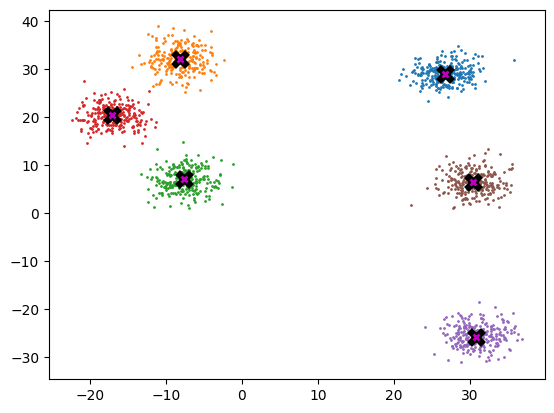

In [131]:
X = data.clone()
data = data.cpu()
plot_data(centroids, data, n_samples)

In [99]:
x = data[0]
x,x.shape,X.shape

(tensor([-14.167, -17.772]), torch.Size([2]), torch.Size([1500, 2]))

In [154]:
def distance(x,X):
  # dis = torch.sqrt(((x-X)**2).sum(1))
  dis = np.linalg.norm(x - X)
  return dis

In [ ]:
distance(x,data)

In [148]:
def region_query(X,point_idx,epsilon):
  neighbors = []
  labels = []
  for i ,x in enumerate(X):
    dis = distance(X[point_idx],x)
    if dis < epsilon:
      neighbors.append(i)

  return neighbors,

In [149]:
def expand_cluster(X,labels,point_idx,neighbors,cluster_id,eps,min_pts):
  labels[point_idx] = cluster_id
  i = 0
  while i < len(neighbors):
    neighbors_idx = neighbors[i]
    if labels[neighbors_idx] == -1:
      labels[neighbors_idx] = cluster_id
    elif labels[neighbors_idx] == 0:
      labels[neighbor_idx] = cluster_id
      new_neighbors = region_query(X,neighbor_idx,eps)
      if len(new_neighbors) > min_pts:
        neighbors +=new_neighbors
    elif labels[neighbors_idx] == 1:
      labels[neighbor_idx] = cluster_id
  i += 1

In [150]:
import numpy as np
def dbscan(X,eps,min_pts):
  n_points = len(X)
  labels = np.zeros(n_points)
  cluster_id = 0

  for point_idx in range(n_points):
    if labels[point_idx] == 0 :
      neighbors = region_query(X,point_idx,eps)
    if len(neighbors) < min_pts:
      labels[point_idx] = -1
    else:
      labels[point_idx] = 1
      cluster_id +=1
      expand_cluster(X,labels,point_idx,neighbors,cluster_id,eps,min_pts)
  return labels

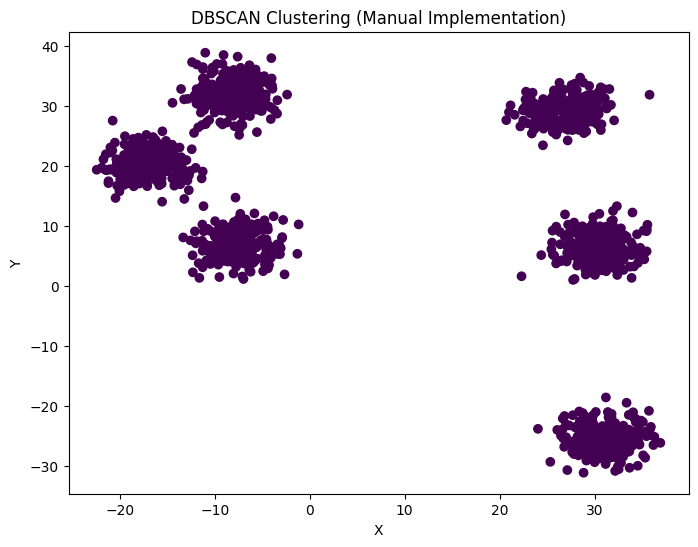

Cluster labels: [-1.]


In [157]:
X = data.clone()
eps = 3
min_pts=10
labels = dbscan(X,eps,min_pts)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering (Manual Implementation)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print(f"Cluster labels: {np.unique(labels)}")

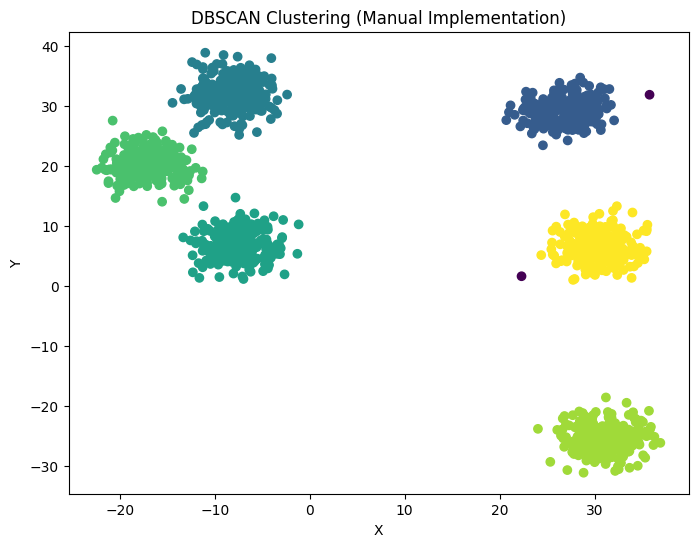

Cluster labels: [-1.  1.  2.  3.  4.  5.  6.]


In [158]:
import numpy as np
import matplotlib.pyplot as plt

# 计算两点之间的欧氏距离
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

# 寻找邻域
def region_query(data, point_idx, eps):
    neighbors = []
    for i, point in enumerate(data):
        if euclidean_distance(data[point_idx], point) < eps:
            neighbors.append(i)
    return neighbors

# 扩展簇
def expand_cluster(data, labels, point_idx, neighbors, cluster_id, eps, min_pts):
    labels[point_idx] = cluster_id  # 将核心点标记为簇的ID
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]
        if labels[neighbor_idx] == -1:  # 如果是噪声点，将其归为当前簇
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0:  # 如果该点还未被标记
            labels[neighbor_idx] = cluster_id
            # 检查该点的邻域
            new_neighbors = region_query(data, neighbor_idx, eps)
            if len(new_neighbors) >= min_pts:  # 如果该点是核心点，则继续扩展
                neighbors += new_neighbors  # 扩展邻域
        i += 1

# DBSCAN聚类算法
def dbscan(data, eps, min_pts):
    n_points = len(data)
    labels = np.zeros(n_points)  # 初始化所有点的标签为0，0表示未访问
    cluster_id = 0  # 聚类ID

    for point_idx in range(n_points):
        if labels[point_idx] == 0:  # 如果该点尚未访问
            neighbors = region_query(data, point_idx, eps)
            if len(neighbors) < min_pts:  # 如果邻域中的点少于min_pts，标记为噪声
                labels[point_idx] = -1
            else:  # 如果是核心点，开始扩展簇
                cluster_id += 1
                expand_cluster(data, labels, point_idx, neighbors, cluster_id, eps, min_pts)

    return labels

# 运行DBSCAN算法
X = data.clone()
eps = 3
min_pts = 10
labels = dbscan(X, eps, min_pts)

# 绘制结果
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering (Manual Implementation)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# 输出聚类结果
print(f"Cluster labels: {np.unique(labels)}")
